### GPU, cuda, gccの確認


In [ ]:
!nvidia-smi
!nvcc --version
!gcc --version

### パッケージのインストール / クリーンインストール
ssh先のjupyter環境などで実行の場合は, 当該環境にパッケージをインストール

In [ ]:
# クリーンが必要であれば実行
!rm -rf kineticEQ
#!rm -rf build

In [ ]:
# インストール
!git clone https://github.com/Minamium/kineticEQ.git
!pip install -e ./kineticEQ

### 動作確認

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image
import math

from kineticEQ import BGK2D2V_core

# =========================
# 1. シミュレーション設定
# =========================
device = "cuda" if torch.cuda.is_available() else "cpu"

nx, ny   = 256, 256
nv_x, nv_y = 16, 16

Lx, Ly   = 1.0, 1.0
vx_max, vy_max = 5.0, 5.0

dt       = 1e-4
T_total  = 2.0
tau_tilde = 5e-4

# 初期モーメント場
# 格子点座標
x = torch.linspace(0.0, Lx, nx)
y = torch.linspace(0.0, Ly, ny)
X, Y = torch.meshgrid(x, y, indexing="ij")

# 密度・温度は一様
n0 = torch.ones((nx, ny))
T0 = torch.ones((nx, ny))

# --- Double shear layer の x方向流速 u_x(y) ---

U0    = 0.5          # 代表速度
delta = 0.05 * Ly    # せん断層の厚み（グリッド ~ 10–15 点程度）

u_x0 = torch.zeros_like(X)

# 下側せん断層（y ≈ 0.25）
mask_lower = (Y <= 0.5 * Ly)
u_x0[mask_lower] = U0 * torch.tanh((Y[mask_lower] - 0.25 * Ly) / delta)

# 上側せん断層（y ≈ 0.75）
mask_upper = ~mask_lower
u_x0[mask_upper] = U0 * torch.tanh((0.75 * Ly - Y[mask_upper]) / delta)

# --- y方向擾乱 u_y(x,y) ---

eps   = 0.1 * U0          # 擾乱振幅
k_x   = 2.0 * math.pi / Lx  # x 方向波数（1 波長）
sigma = 0.05 * Ly         # せん断層近傍に局在させる幅

# せん断層近傍 (y=0.25, 0.75) にガウス分布で重みを付けた擾乱
perturb = eps * torch.sin(k_x * X) * (
    torch.exp(-((Y - 0.25 * Ly)**2) / (2.0 * sigma**2)) +
    torch.exp(-((Y - 0.75 * Ly)**2) / (2.0 * sigma**2))
)

u_y0 = perturb


# =========================
# 2. インスタンス生成 & 実行
# =========================
bgk = BGK2D2V_core(
    nx=nx,
    ny=ny,
    nv_x=nv_x,
    nv_y=nv_y,
    dt=dt,
    T_total=T_total,
    Lx=Lx,
    Ly=Ly,
    vx_max=vx_max,
    vy_max=vy_max,
    tau_tilde=tau_tilde,
    n=n0,
    u_x=u_x0,
    u_y=u_y0,
    T=T0,
    device=device,
    dtype="float64",
    use_tqdm=True,
    flag_record_state=True,   # アニメーション用に時系列を記録
)

bgk.run_simulation()

states = bgk.animation_data
print(f"Recorded frames: {len(states)}")

  nx=256, ny=256, nv_x=16, nv_y=16
  dx=0.00390625, dy=0.00390625, dv_x=0.625, dv_y=0.625
  dt=0.0001, T_total=2.0, nt=20000
  tau_tilde=0.0005
  explicit_advection_scheme=MUSCL2
  dtype: float64
  device: cuda, GPU name: NVIDIA A30, Total memory: 23.60 GB
 --- Array allocation ---
 --- Initialize fields ---
  CFL numbers: Cx=0.128000, Cy=0.128000, Cx+Cy=0.256000
  CFL condition satisfied.
 --- run simulation ---


Explicit Evolution: 100%|██████████| 20000/20000 [08:29<00:00, 39.28it/s]

--- run simulation complete, Result is saved in self.f, self.u_x, self.u_y, self.T ---
Recorded frames: 51


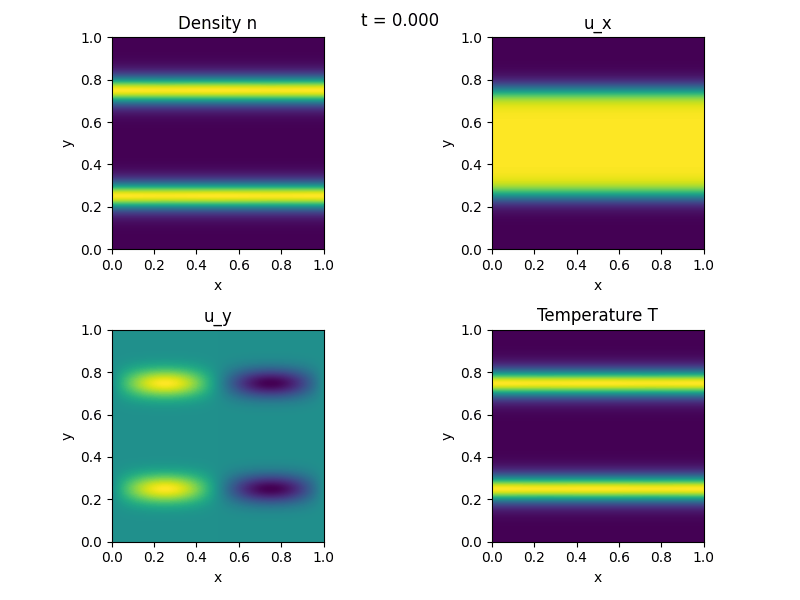

In [2]:
# =========================
# 3. アニメーション (GIF) 作成
# =========================
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
ax_n, ax_ux, ax_uy, ax_T = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]

Lx, Ly = bgk.Lx, bgk.Ly

frame0 = states[0]
n_img  = ax_n.imshow(frame0["n"].T,   origin="lower", extent=[0, Lx, 0, Ly])
ux_img = ax_ux.imshow(frame0["u_x"].T, origin="lower", extent=[0, Lx, 0, Ly])
uy_img = ax_uy.imshow(frame0["u_y"].T, origin="lower", extent=[0, Lx, 0, Ly])
T_img  = ax_T.imshow(frame0["T"].T,   origin="lower", extent=[0, Lx, 0, Ly])

ax_n.set_title("Density n")
ax_ux.set_title("u_x")
ax_uy.set_title("u_y")
ax_T.set_title("Temperature T")

for ax in [ax_n, ax_ux, ax_uy, ax_T]:
    ax.set_xlabel("x")
    ax.set_ylabel("y")

fig.tight_layout()

def update(frame_idx):
    state = states[frame_idx]
    n_img.set_data(state["n"].T)
    ux_img.set_data(state["u_x"].T)
    uy_img.set_data(state["u_y"].T)
    T_img.set_data(state["T"].T)
    fig.suptitle(f"t = {state['time']:.3f}")
    return [n_img, ux_img, uy_img, T_img]


anim = animation.FuncAnimation(
    fig,
    update,
    frames=len(states),
    interval=100,   # 1フレーム 100 ms
    blit=False,
)

gif_name = "bgk2d2v_moments.gif"
anim.save(gif_name, writer=animation.PillowWriter(fps=10))
plt.close(fig)  # 静止画表示を抑制

# =========================
# 4. ノートブック上で GIF 再生
# =========================
Image(filename=gif_name)